# BasketBall Data Prediction Using Advanced DeepLearning

**This dataset covers about 30 years of data and has about 400 unique schools. Revealing around 12,000 IDs. Only around 11,000 of those year/team combinations are present, because not every school has a basketball team every year**

## Keras Functional API

**Importing necessary libraries**

In [2]:
import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import unique

from matplotlib import pyplot as plt
from scipy.special import expit as sigmoid

from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import Subtract, Concatenate
from keras.models import Model
from keras.utils import plot_model

**Read Data File**

In [2]:
games_season = pd.read_csv('games_season.csv')
games_season.head()

,season,team_1,team_2,home,score_diff,score_1,score_2,won
0,1985,3745,6664,0,17,81,64,1
1,1985,126,7493,1,7,77,70,1
2,1985,288,3593,1,7,63,56,1
3,1985,1846,9881,1,16,70,54,1
4,1985,2675,10298,1,12,86,74,1


In [3]:
games_tourney = pd.read_csv('games_tourney.csv')
games_tourney.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
0,1985,288,73,0,-3,-9,41,50,0
1,1985,5929,73,0,4,6,61,55,1
2,1985,9884,73,0,5,-4,59,63,0
3,1985,73,288,0,3,9,50,41,1
4,1985,3920,410,0,1,-9,54,63,0


In [4]:
games_tourney.tail()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
4229,2017,10120,10696,0,-1,-10,74,84,0
4230,2017,320,10818,0,9,-2,71,73,0
4231,2017,2910,10818,0,8,-25,66,91,0
4232,2017,3300,10818,0,10,24,83,59,1
4233,2017,4973,10818,0,5,-11,65,76,0


### Keras Models

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
Predicted-Score-Diff (Dense) (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


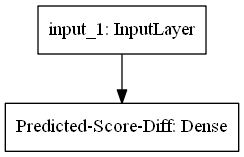

In [5]:
input_tensor = Input(shape=(1,))
output_layer = Dense(1, name='Predicted-Score-Diff')
output_tensor = output_layer(input_tensor)

model = Model(input_tensor, output_tensor)
# should compile the model before fitting it to data
model.compile(optimizer='adam', loss='mae')
model.summary()
plot_model(model, to_file='model.png')

### Plotting Model before fitting

In [1]:
img = plt.imread('model.png')
plt.imshow(img)
plt.show()

NameError: name 'plt' is not defined

### Fit and Evaluate Model

**Goal is to Predict tournament Outcomes**

In [7]:
games = read_csv('games_tourney.csv')
model.fit(games['seed_diff'],
          games['score_diff'],
          epochs=1,
          batch_size=128,  # how many rows of data are used for each step of stochastic gradient descent
          # to use a holdout set and return metrics on accuracy using that data
          validation_split=0.10,
          verbose=True)  # prints a log during training

30/30 [==============================] - 0s 14ms/step - loss: 13.8642 - val_loss: 13.5992


**Evaluate Model**

In [8]:
# Load the X variable from the test data
X_test = games['seed_diff']

# Load the y variable from the test data
y_test = games['score_diff']

# Evaluate the model on the test data
print(model.evaluate(X_test, y_test, verbose=False))

13.77394962310791


## Two Input Networks Using Categorical Embeddings, Shared Layers, and Merge Layers

In [10]:
n_teams = unique(games_season['team_1']).shape[0]
n_teams

10888

### Categorical Embeddings

In [11]:
input_tensor = Input(shape=(1,))
n_teams = unique(games_season['team_1']).shape[0]
embed_layer = Embedding(input_dim=n_teams,
                        input_length=1,  # each team represented as a single integer
                        output_dim=1,
                        name='Team-Strength-Lookup')
embed_tensor = embed_layer(input_tensor)
flatten_tensor = Flatten()(embed_tensor)
team_strength_model = Model(input_tensor, flatten_tensor)

### Shared Layers

In [12]:
# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

### Merged Layers

In [13]:
# Create a subtract layer
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

**Predict Model**

In [14]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=0.10,
          verbose=True)

138/138 [==============================] - 1s 7ms/step - loss: 12.1200 - val_loss: 11.8380


Model has now learnt strength rating for every team

**In this exercise, you will evaluate the model on this new dataset. This evaluation will tell you how well you can predict the tournament games, based on a model trained with the regular season data. This is interesting because many teams play each other in the tournament that did not play in the regular season, so this is a very good check that your model is not over fitting.**

In [16]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2],
                     games_tourney['score_diff'], verbose=False))

11.681224822998047


## Multiple Inputs

### Three-Input Models

In [18]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [19]:
model = Model([team_in_1, team_in_2, home_in], out)
model.compile(optimizer='adam', loss='mean_absolute_error')

In [20]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=.10,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']],
                     games_tourney['score_diff'], verbose=False))

138/138 [==============================] - 1s 7ms/step - loss: 12.0885 - val_loss: 11.9800
11.671454429626465


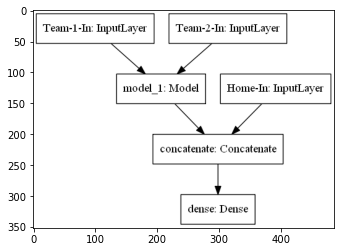

In [21]:
# Plot the model
plot_model(model, to_file='model1.png')

# Display the image
data = plt.imread('model1.png')
plt.imshow(data)
plt.show()

### Model Stacking

*Here I tried to improve the model by using a form of model stacking by utilizing prediction from the regular season model as an input to the tournament model.*

In [22]:
games_tourney['pred'] = model.predict([games_tourney['team_1'],
                                       games_tourney['team_2'],
                                       games_tourney['home']])

In [26]:
games_tourney_train = games_tourney[[
    'home', 'seed_diff', 'score_1', 'score_2', 'score_diff', 'won', 'pred']]
games_tourney_test = games_tourney[[
    'home', 'seed_diff', 'score_1', 'score_2', 'score_diff', 'won', 'pred']]

In [27]:
# Input layer with 3 columns
input_tensor = Input((3,))

# Pass it to Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Model
model = Model(input_tensor, output_tensor)

# Compile
model.compile(optimizer='adam', loss='mean_absolute_error')

train_X = games_tourney_train[['home', 'seed_diff', 'pred']]
train_y = games_tourney_train['score_diff']


model.fit(train_X,
          train_y,
          epochs=10,
          validation_split=0.10,
          verbose=True)

Epoch 1/10
120/120 [==============================] - 0s 3ms/step - loss: 12.1035 - val_loss: 11.6729
Epoch 2/10
120/120 [==============================] - 0s 4ms/step - loss: 11.6735 - val_loss: 11.2534
Epoch 3/10
120/120 [==============================] - 0s 3ms/step - loss: 11.2645 - val_loss: 10.8504
Epoch 4/10
120/120 [==============================] - 0s 3ms/step - loss: 10.8932 - val_loss: 10.4786
Epoch 5/10
120/120 [==============================] - 0s 3ms/step - loss: 10.5655 - val_loss: 10.1469
Epoch 6/10
120/120 [==============================] - 0s 4ms/step - loss: 10.2837 - val_loss: 9.8738
Epoch 7/10
120/120 [==============================] - 0s 4ms/step - loss: 10.0584 - val_loss: 9.6383
Epoch 8/10
120/120 [==============================] - 0s 2ms/step - loss: 9.8622 - val_loss: 9.4325
Epoch 9/10
120/120 [==============================] - 0s 2ms/step - loss: 9.7043 - val_loss: 9.2633
Epoch 10/10
120/120 [==============================] - 0s 3ms/step - loss: 9.5772 - val_

In [28]:
test_X = games_tourney_test[['home', 'seed_diff', 'pred']]
test_y = games_tourney_test['score_diff']
model.evaluate(test_X, test_y, verbose=False)

9.484526634216309

## Multiple Outputs

### Two-Output Models

In [29]:
# Define the input
input_tensor = Input(shape=(2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [32]:
model.fit(games_tourney_train[['seed_diff', 'pred']],
          games_tourney_train[['score_1', 'score_2']],
          verbose=True,
          epochs=100,
          batch_size=16384)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 71.1357
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 71.1346
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 71.1334
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 71.1323
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 71.1311
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 71.1300
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 71.1288
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 71.1277
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 71.1265
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 71.1253
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 71.1242
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 71.1231
Epoch 13/100
1/1 [==============================]

In [33]:
# Model's weights
print(model.get_weights())

# Column means of the training data
print(games_tourney.mean())

[array([[-0.22301827,  0.48647183],
       [-0.5035681 , -0.69791496]], dtype=float32), array([0.20000015, 0.20000015], dtype=float32)]
season        2001.193198
team_1        5589.146906
team_2        5589.146906
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.131318
score_2         71.131318
won              0.500000
pred             0.148951
dtype: float64


**It can be noticed that both output weights are about ~72. This is because, on average, a team will score about 72 points in the tournament.**

In [34]:
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
                     games_tourney_test[['score_1', 'score_2']], verbose=False))

71.02082824707031


### Single Model for Classification and regression

In [35]:
# Create an input layer with 2 columns
input_tensor = Input(shape=(2,))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid',
                        use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

In [37]:
# Import the Adam optimizer
from keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error',
                    'binary_crossentropy'], optimizer=Adam(.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=500,
          verbose=True,
          batch_size=16384)

Epoch 1/500
1/1 [==============================] - 0s 4ms/step - loss: 10.4779 - dense_5_loss: 9.3906 - dense_6_loss: 1.0872
Epoch 2/500
1/1 [==============================] - 0s 3ms/step - loss: 10.4652 - dense_5_loss: 9.3765 - dense_6_loss: 1.0888
Epoch 3/500
1/1 [==============================] - 0s 3ms/step - loss: 10.4526 - dense_5_loss: 9.3625 - dense_6_loss: 1.0901
Epoch 4/500
1/1 [==============================] - 0s 4ms/step - loss: 10.4401 - dense_5_loss: 9.3489 - dense_6_loss: 1.0912
Epoch 5/500
1/1 [==============================] - 0s 2ms/step - loss: 10.4278 - dense_5_loss: 9.3359 - dense_6_loss: 1.0919
Epoch 6/500
1/1 [==============================] - 0s 2ms/step - loss: 10.4158 - dense_5_loss: 9.3234 - dense_6_loss: 1.0923
Epoch 7/500
1/1 [==============================] - 0s 2ms/step - loss: 10.4039 - dense_5_loss: 9.3115 - dense_6_loss: 1.0924
Epoch 8/500
1/1 [==============================] - 0s 2ms/step - loss: 10.3920 - dense_5_loss: 9.3000 - dense_6_loss: 1.0920


1/1 [==============================] - 0s 4ms/step - loss: 9.6917 - dense_5_loss: 9.1387 - dense_6_loss: 0.5530
Epoch 132/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6917 - dense_5_loss: 9.1387 - dense_6_loss: 0.5530
Epoch 133/500
1/1 [==============================] - 0s 5ms/step - loss: 9.6917 - dense_5_loss: 9.1387 - dense_6_loss: 0.5530
Epoch 134/500
1/1 [==============================] - 0s 5ms/step - loss: 9.6917 - dense_5_loss: 9.1387 - dense_6_loss: 0.5530
Epoch 135/500
1/1 [==============================] - 0s 3ms/step - loss: 9.6916 - dense_5_loss: 9.1386 - dense_6_loss: 0.5530
Epoch 136/500
1/1 [==============================] - 0s 6ms/step - loss: 9.6916 - dense_5_loss: 9.1386 - dense_6_loss: 0.5530
Epoch 137/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6916 - dense_5_loss: 9.1386 - dense_6_loss: 0.5530
Epoch 138/500
1/1 [==============================] - 0s 5ms/step - loss: 9.6916 - dense_5_loss: 9.1386 - dense_6_loss: 0.5530
Epoch 

1/1 [==============================] - 0s 6ms/step - loss: 9.6900 - dense_5_loss: 9.1369 - dense_6_loss: 0.5530
Epoch 262/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6900 - dense_5_loss: 9.1369 - dense_6_loss: 0.5530
Epoch 263/500
1/1 [==============================] - 0s 3ms/step - loss: 9.6899 - dense_5_loss: 9.1369 - dense_6_loss: 0.5530
Epoch 264/500
1/1 [==============================] - 0s 7ms/step - loss: 9.6899 - dense_5_loss: 9.1369 - dense_6_loss: 0.5530
Epoch 265/500
1/1 [==============================] - 0s 3ms/step - loss: 9.6899 - dense_5_loss: 9.1369 - dense_6_loss: 0.5530
Epoch 266/500
1/1 [==============================] - 0s 3ms/step - loss: 9.6899 - dense_5_loss: 9.1369 - dense_6_loss: 0.5530
Epoch 267/500
1/1 [==============================] - 0s 3ms/step - loss: 9.6899 - dense_5_loss: 9.1369 - dense_6_loss: 0.5530
Epoch 268/500
1/1 [==============================] - 0s 4ms/step - loss: 9.6899 - dense_5_loss: 9.1369 - dense_6_loss: 0.5530
Epoch 

1/1 [==============================] - 0s 985us/step - loss: 9.6897 - dense_5_loss: 9.1366 - dense_6_loss: 0.5531
Epoch 392/500
1/1 [==============================] - 0s 2ms/step - loss: 9.6897 - dense_5_loss: 9.1366 - dense_6_loss: 0.5531
Epoch 393/500
1/1 [==============================] - 0s 971us/step - loss: 9.6897 - dense_5_loss: 9.1366 - dense_6_loss: 0.5531
Epoch 394/500
1/1 [==============================] - 0s 2ms/step - loss: 9.6897 - dense_5_loss: 9.1366 - dense_6_loss: 0.5531
Epoch 395/500
1/1 [==============================] - 0s 996us/step - loss: 9.6897 - dense_5_loss: 9.1366 - dense_6_loss: 0.5531
Epoch 396/500
1/1 [==============================] - 0s 997us/step - loss: 9.6897 - dense_5_loss: 9.1366 - dense_6_loss: 0.5531
Epoch 397/500
1/1 [==============================] - 0s 998us/step - loss: 9.6897 - dense_5_loss: 9.1366 - dense_6_loss: 0.5531
Epoch 398/500
1/1 [==============================] - 0s 2ms/step - loss: 9.6897 - dense_5_loss: 9.1366 - dense_6_loss: 0.5

In [38]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games_tourney_train.mean())

[array([[1.1728618],
       [2.8026264]], dtype=float32), array([[0.14132501]], dtype=float32)]
home           0.000000
seed_diff      0.000000
score_1       71.131318
score_2       71.131318
score_diff     0.000000
won            0.500000
pred           0.148951
dtype: float64


In [39]:
# Weight from the model
weight = 0.14

# Print the approximate win probability of a predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability of a predicted blowout game
print(sigmoid(10 * weight))

0.5349429451582145
0.8021838885585818


In [40]:
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
                     [games_tourney_test[['score_diff']], games_tourney_test[['won']]], verbose=False))

[9.689717292785645, 9.136591911315918, 0.5531251430511475]


## Conclusion

* 9.69 = Loss function used by the model, which is sum of all output losses


* 9.14 = Loss for regression part of the model, Therefore, this model has a mean absolute error of 9.13


* 0.55 = Loss for classification part of the model, Logloss of 0.58